# Face_Detector with MTCNN
1. 利用MTCNN偵測出影像上的人臉並做Bounding box
2. 可做單人和多人
3. 嘗試在單人影像辨識出多個人臉的情形中取出正確的那一張人臉

# 完整流程
1. 讀取資料
2. MTCNN-landmarks
3. Face alignment
4. MTCNN-face location
5. Resize and black border

In [ ]:
!pip install --user mtcnn
!pip install --user keras==2.2.5
!pip install --user tensorflow-gpu==1.14.0

In [178]:
# 將警告訊息關掉
import warnings
warnings.filterwarnings('ignore')

# 系統套件
import os

# 深度學習套件
import tensorflow as tf
import keras
from mtcnn import MTCNN

# 影像處理
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# 運算套件
import math
import numpy as np
import pandas as pd

In [249]:
# 讀取圖片後進行 Face_location
# 取出 Bounding box的四個點和五點 landmark
# 取出多張人臉後比較 Bounding box大小，取最大的為我們要的人臉
# 輸出為裁剪後的人臉
detector = MTCNN()
def face_location(img):

#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    draw = img.copy()  # 複製輸入的原圖
    face = detector.detect_faces(draw)  # MTCNN偵測人臉可傳回 Bounding_Box 和 5點 Landmarks
    main_face = []     # 存放一張圖像中的人臉大小，最後要取最大的作為輸出
    main_face_idx = 0
    
    for idx, location in enumerate(face):    # 每張圖片可能有多張人臉，依序讀取後進行 bounding box和擷取
        
        #print(idx, location)
        #print('\n')
    
        x, y, width, height = location['box']  # 取出 Bounding box的四個點
        
        # 取出左上角座標 (x,y)與右下角座標 (x+width,y+height)
        # 由於有可能預測出來的臉在圖像的圖邊而導致座標值為負值
        # 因此進行的負值的偵測與修正
        x = x if x > 0 else 0
        y = y if y > 0 else 0
        width = width if width > 0 else 0
        height = height if height > 0 else 0
    
    
        # 在原圖像上畫上這些邊界框   
        #cv2.rectangle(draw, (x+width, y+height), (x, y), (0, 255, 0), 5) # (0, 255, 0)-留下綠色, 5為線條粗度
        #plt.imshow(draw)
    
        # 依序儲存多張人臉
        main_face.append(width*height)
      
    
    # 從多張人臉篩選出要的那一張   
    # print('共辨識出%d張人臉' % len(face))
    main_face_idx = np.argmax(main_face)
        
    # 裁減前修正
    x_new, y_new, width_new, height_new = face[main_face_idx]['box']
    x_new = x_new if x_new > 0 else 0
    y_new = y_new if y_new > 0 else 0
    width_new = width_new if width_new > 0 else 0
    height_new = height_new if height_new > 0 else 0
    
    # 進行臉部圖像裁剪
    crop=img[y_new:y_new+height_new,x_new:x_new+width_new,]
    keypoints = face[main_face_idx]['keypoints']
   
    # 把臉部大小進行大小的修改便拋出給其它模組進行辨識(face recognition)
    # 在函數中進行解析度縮小會造成錯誤，因此於輸出擷取的圖像後再進行圖像縮小 
    
    
    return len(face), crop, keypoints

In [250]:
# 畫出landmark
#於landmarks上畫圓，標識特徴點
def renderFace(img, landmarks, color=(0, 255, 0), radius=5):
    for point in landmarks.keys():
        draw = img.copy()
        cv2.circle(draw, landmarks[point], radius, color, -1)
        img = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
        

In [251]:
# 臉部旋轉
def align_face(image_array, landmarks):
    """ align faces according to eyes position
    :param image_array: numpy array of a single image
    :param landmarks: dict of landmarks for facial parts as keys and tuple of coordinates as values
    :return:
    rotated_img:  numpy array of aligned image
    eye_center: tuple of coordinates for eye center
    angle: degrees of rotation
    """
    # get list landmarks of left and right eye
    left_eye = np.array(landmarks['left_eye'])
    right_eye = np.array(landmarks['right_eye'])
    # calculate the mean point of landmarks of left and right eye
#     left_eye_center = np.mean(left_eye, axis=0).astype("int")     # 使用MTCNN的話不需要另外計算中心點
#     right_eye_center = np.mean(right_eye, axis=0).astype("int")
    left_eye_center = left_eye.astype('int')
    right_eye_center = right_eye.astype('int')
    # compute the angle between the eye centroids
    dy = right_eye_center[1] - left_eye_center[1]
    dx = right_eye_center[0] - left_eye_center[0]
    # compute angle between the line of 2 centeroids and the horizontal line
    angle = math.atan2(dy, dx) * 180. / math.pi
    # calculate the center of 2 eyes
    eye_center = ((left_eye_center[0] + right_eye_center[0]) // 2,
                  (left_eye_center[1] + right_eye_center[1]) // 2)
    # at the eye_center, rotate the image by the angle
    rotate_matrix = cv2.getRotationMatrix2D(eye_center, angle, scale=1)
    rotated_img = cv2.warpAffine(image_array, rotate_matrix, (image_array.shape[1], image_array.shape[0]))
    return rotated_img, eye_center, angle


In [252]:
# 裁減並增加黑邊-以防失真
#按照指定影象大小調整尺寸
IMAGE_SIZE = 224

def resize_image(image, height = IMAGE_SIZE, width = IMAGE_SIZE):
    top, bottom, left, right = (0, 0, 0, 0)
    
    #獲取影象尺寸
    h, w, _ = image.shape
    
    #對於長寬不相等的圖片，找到最長的一邊
    longest_edge = max(h, w)    
    
    #計算短邊需要增加多上畫素寬度使其與長邊等長
    if h < longest_edge:
        dh = longest_edge - h
        top = dh // 2
        bottom = dh - top
    elif w < longest_edge:
        dw = longest_edge - w
        left = dw // 2
        right = dw - left
    else:
        pass 
    
    #RGB顏色
    BLACK = [0, 0, 0]
    
    #給影象增加邊界，是圖片長、寬等長，cv2.BORDER_CONSTANT指定邊界顏色由value指定
    constant = cv2.copyMakeBorder(image, top , bottom, left, right, cv2.BORDER_CONSTANT, value = BLACK)
    
    #調整影象大小並返回
    return cv2.resize(constant, (height, width))

In [253]:
# 專案的根目錄路徑
ROOT_DIR = os.getcwd()

# 資料集目錄
DATA_PATH = os.path.join(ROOT_DIR, 'Data')

# 訓練/驗證的圖像資料目錄
TRAIN_IMGS_PATH = os.path.join(DATA_PATH, 'training_set')
TEST_IMGS_PATH = os.path.join(DATA_PATH, 'testing_set')

In [280]:
# 載入分類的 Label
# 用來對訓練資料即進行分類
dict_Category = {}
classmap = pd.read_csv('./Data/classmap.csv', header = None)

for idx, label in classmap.iterrows():
    dict_Category[label[0]] = label[1]
dict_Category

{'classname': 'classnum',
 'rika': '0',
 'risa': '1',
 'yui': '2',
 'akane': '3',
 'neru': '4',
 'other': '5'}

In [297]:
def load_data(path,label):
    imageList = []
    labelList = []
    imgs = os.listdir(path)
    
    for imgname in imgs:
        if(imgname[-4:] == ".png"):
            img = cv2.imread(path+ imgname, cv2.IMREAD_COLOR)                                                                                                                                                                                                                                        
            print(path+ imgname)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            draw = img.copy()
#             img = img[:,:,::-1] # BGR轉RGB
            image_count, crop, keypoints = face_location(img)  # Landmarks
            rotate_img, _, _ = align_face(draw, keypoints)     # Face alignment
            _, rotate_crop, _ = face_location(rotate_img)      # Crop
            resize_crop = resize_image(rotate_crop)            # Resize
            #crop = crop.astype(np.float32)
                                       
            imageList.append(resize_crop)
            labelList.append(label)
            print("照片共辨識出 {} 張臉。".format(image_count))
            
    return imageList,labelList

In [313]:
# 對訓練資料集進行類別 Label
TrainDirectory = TRAIN_IMGS_PATH
labelnames = os.listdir(TrainDirectory) # 列出有幾個要分類的人, 每個人的圖像放在一個資料集，因此五人則是五個資料集
total_img=[]
total_label=[]
print(labelnames)

for labelname in labelnames:
    imageList,labelList = load_data(TrainDirectory+'/'+labelname+'/',dict_Category[labelname])
    total_img = total_img + imageList;
    total_label = total_label+labelList;
    print(labelname,'-'*3,len(imageList))

total_img=np.asarray(total_img)

# 對 label進行 OneHotEncoding
labelnames = keras.utils.to_categorical(total_label,len(labelnames))    

['akane', 'neru', 'other', 'rika', 'risa', 'yui']
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/akane/000.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/akane/001.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/akane/002.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/akane/003.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/akane/004.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/akane/005.png
照片共辨識出 3 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/akane/006.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/akane/007.png
照片共辨識出 2 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/akane/008.png
照片共辨識出 3 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/akane/009.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\

照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/akane/091.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/akane/092.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/akane/093.png
照片共辨識出 2 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/akane/094.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/akane/095.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/akane/096.png
照片共辨識出 5 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/akane/097.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/akane/098.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/akane/099.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/akane/100.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/ak

照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/neru/079.png
照片共辨識出 2 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/neru/080.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/neru/081.png
照片共辨識出 3 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/neru/082.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/neru/083.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/neru/084.png
照片共辨識出 12 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/neru/085.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/neru/086.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/neru/087.png
照片共辨識出 2 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/neru/088.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/neru/089.pn

照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/rika/054.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/rika/055.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/rika/056.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/rika/057.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/rika/058.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/rika/059.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/rika/060.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/rika/061.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/rika/062.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/rika/063.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/rika/064.png

照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/risa/046.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/risa/047.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/risa/048.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/risa/049.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/risa/050.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/risa/051.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/risa/052.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/risa/053.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/risa/054.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/risa/055.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/risa/056.png

照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/yui/039.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/yui/040.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/yui/041.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/yui/042.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/yui/043.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/yui/045.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/yui/046.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/yui/047.png
照片共辨識出 2 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/yui/048.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/yui/049.png
照片共辨識出 1 張臉。
C:\Users\foresight\Desktop\AI\Face Recognition\Data\training_set/yui/050.png
照片共辨識出 1 張

In [314]:
# 儲存前處理完的資料
np.save('total_crop_resized_224.npy', total_img)
np.save('labelnames', labelnames)

In [ ]:
# 把臉部大小進行大小的修改便拋出給其它模組進行辨識(face recognition)
# 在函數中進行解析度縮小會造成錯誤，因此於輸出擷取的圖像後再進行圖像縮小
# total_img_resized = []
# for crop in total_img:
#     crop_resized = cv2.resize(crop, (224, 224), interpolation=cv2.INTER_CUBIC)  # 降低解析度並縮放為正方形  
#     total_img_resized.append(crop_resized)
# total_img_resized = np.asarray(total_img_resized)
# print(total_img_resized.shape)
# print(labelnames.shape)
# np.save('total_crop_resized.npy', total_img_resized)
# np.save('labelnames', labelnames)

ValueError: attempt to get argmax of an empty sequence

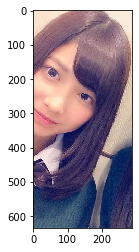

In [303]:
img = cv2.imread('C:/Users/foresight/Desktop/AI/Face Recognition/Data/training_set/risa/063.png', cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

num_face, crop , keypoints= face_location(img)
print(num_face)
plt.imshow(crop)
print(keypoints)

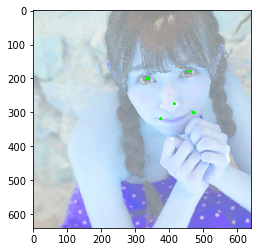

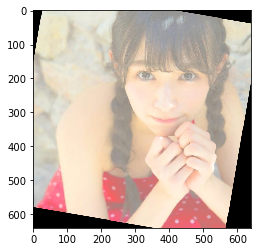

In [295]:
renderFace(img, keypoints)
plt.show()
A, B, C = align_face(img, keypoints)
plt.imshow(A)

In [296]:
num, face , _= face_location(A)
plt.imshow(face)

ValueError: attempt to get argmax of an empty sequence

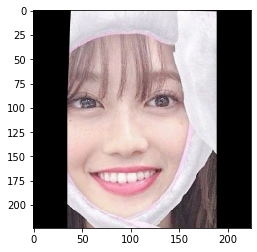

In [238]:
resize = resize_image(face)
plt.imshow(resize)